In [47]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

In [11]:
# load datasets
labels_data = pd.read_csv('dataset_Seminar3/labels_data.csv', header=None)
rssi_data = pd.read_csv('dataset_Seminar3/rssi_data.csv', header=None)

labels_data.columns = ['position']
rssi_data.columns = ['AP1', 'AP2', 'AP3']

# Part I: Data preparation & analysis

### 2D Plots: RSSI Perceived by Each Pair of APs

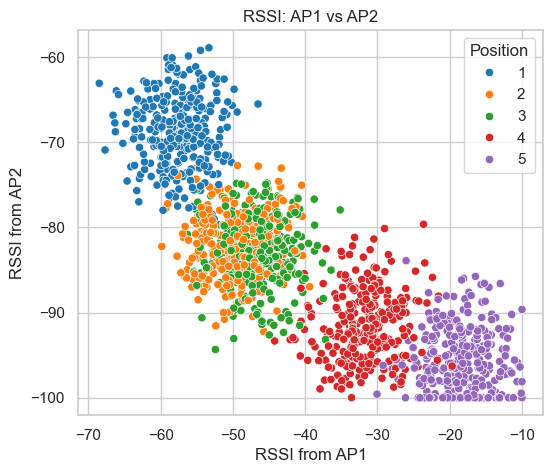

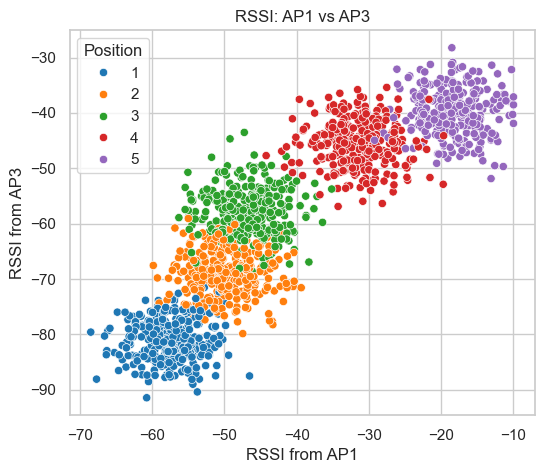

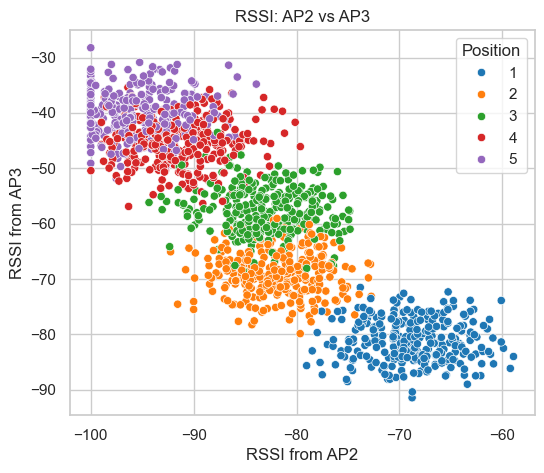

In [12]:
sns.set(style='whitegrid') # style the visuals

# 2D plot: AP1 vs AP2
plt.figure(figsize=(6, 5))
sns.scatterplot(data=rssi_data, x='AP1', y='AP2', hue=labels_data['position'], palette='tab10')
plt.title('RSSI: AP1 vs AP2')
plt.xlabel('RSSI from AP1')
plt.ylabel('RSSI from AP2')
plt.legend(title='Position')
plt.show()

# 2D plot: AP1 vs AP3
plt.figure(figsize=(6, 5))
sns.scatterplot(data=rssi_data, x='AP1', y='AP3', hue=labels_data['position'], palette='tab10')
plt.title('RSSI: AP1 vs AP3')
plt.xlabel('RSSI from AP1')
plt.ylabel('RSSI from AP3')
plt.legend(title='Position')
plt.show()

# 2D plot: AP2 vs AP3
plt.figure(figsize=(6, 5))
sns.scatterplot(data=rssi_data, x='AP2', y='AP3', hue=labels_data['position'], palette='tab10')
plt.title('RSSI: AP2 vs AP3')
plt.xlabel('RSSI from AP2')
plt.ylabel('RSSI from AP3')
plt.legend(title='Position')
plt.show()

### 3D Plot: RSSI from All Three APs

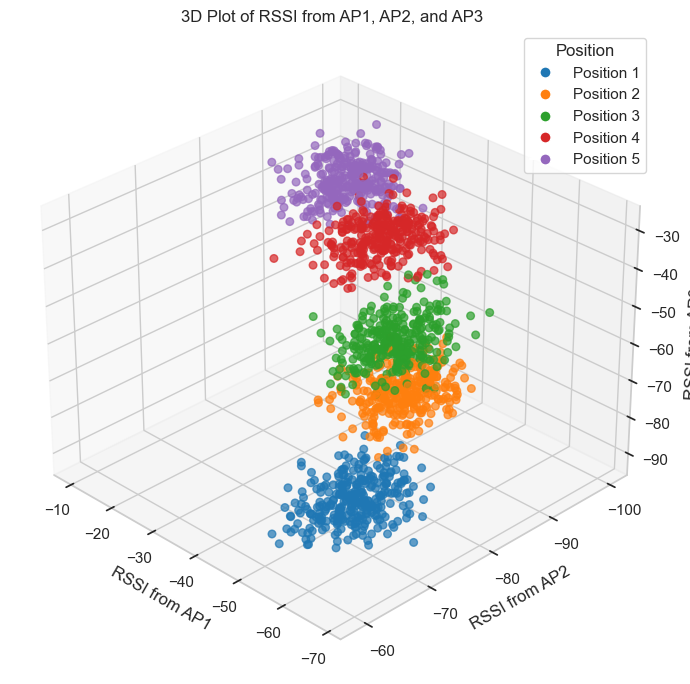

In [40]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Convert labels to a categorical color map
colors = sns.color_palette('tab10', n_colors=labels_data['position'].nunique())
color_map = dict(zip(sorted(labels_data['position'].unique()), colors))
point_colors = labels_data['position'].map(color_map)

# Scatter plot with better visibility
ax.scatter(
    rssi_data['AP1'],
    rssi_data['AP2'],
    rssi_data['AP3'],
    c=point_colors,
    s=30,           # bigger marker size
    alpha=0.7       # add transparency
)

# Axes labels
ax.set_xlabel('RSSI from AP1')
ax.set_ylabel('RSSI from AP2')
ax.set_zlabel('RSSI from AP3')

# Title and legend
ax.set_title('3D Plot of RSSI from AP1, AP2, and AP3')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Position {l}',
           markerfacecolor=c, markersize=8)
    for l, c in color_map.items()
]
ax.legend(handles=legend_elements, title='Position')

# Rotate the 3D view: (elev=angle up/down, azim=rotation around z-axis)
ax.view_init(elev=30, azim=135)

plt.tight_layout()
plt.show()

### Mean and Std of RSSI

In [35]:
# Combine RSSI data with position labels
data = rssi_data.copy()
data['position'] = labels_data['position']

# Group by position and calculate mean and std for each AP
rssi_mean = data.groupby('position')[['AP1', 'AP2', 'AP3']].mean()
rssi_std = data.groupby('position')[['AP1', 'AP2', 'AP3']].std()

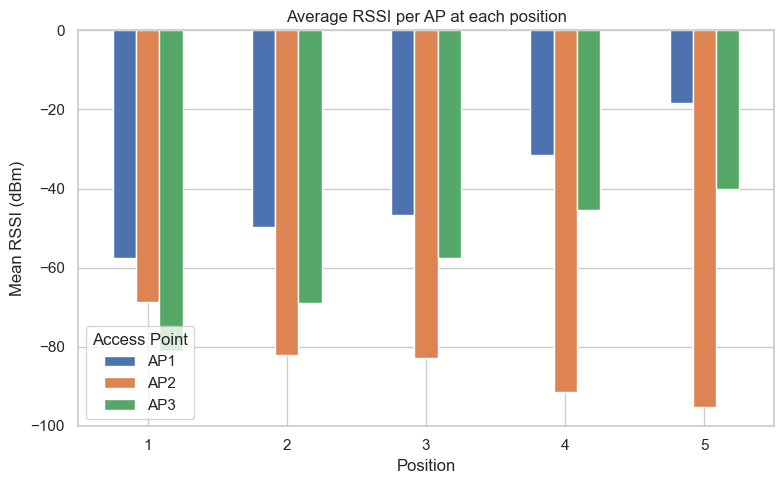

In [37]:
rssi_mean.plot(kind='bar', figsize=(8, 5))
plt.title('Average RSSI per AP at each position')
plt.xlabel('Position')
plt.ylabel('Mean RSSI (dBm)')
plt.xticks(rotation=0)
plt.legend(title='Access Point')
plt.grid(True)
plt.tight_layout()
plt.show()

- Access point 1 is the best for all positions (less noise).

- Access point 2 is the worse in all positions (more noise).

- Position 1 seems to be the most centered position (almost equally close to all access points).

- Position 5 seems to be very close to access point 1 and far from access point 2.

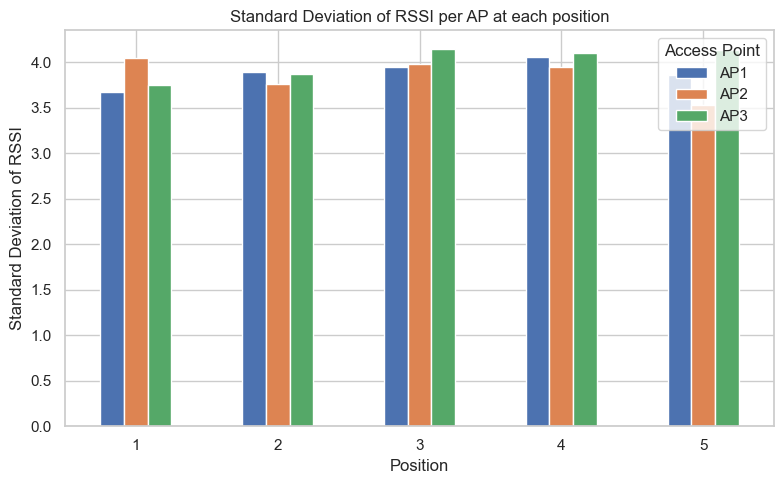

In [38]:
rssi_std.plot(kind='bar', figsize=(8, 5))
plt.title('Standard Deviation of RSSI per AP at each position')
plt.xlabel('Position')
plt.ylabel('Standard Deviation of RSSI')
plt.xticks(rotation=0)
plt.legend(title='Access Point')
plt.grid(True)
plt.tight_layout()
plt.show()

# Part II: k-means implementation

In [42]:
# Set seed for reproducibility
np.random.seed(42)

# Prepare data (only the RSSI values)
X = rssi_data.values
K = 5  # number of clusters (positions)
T = 100  # max iterations

# Step 1: Randomly initialize centroids in 3D space
centroids = X[np.random.choice(X.shape[0], K, replace=False)]

# Track assignments and convergence
assignments = np.zeros(X.shape[0], dtype=int)
prev_assignments = np.ones(X.shape[0]) * -1

# Step 2: Iterative process
for iteration in range(T):
    # Assign each point to the nearest centroid
    for i, point in enumerate(X):
        distances = np.linalg.norm(point - centroids, axis=1)
        assignments[i] = np.argmin(distances)

    # Check convergence (assignments haven't changed)
    if np.all(assignments == prev_assignments):
        print(f'Converged after {iteration} iterations')
        break

    # Update centroids: mean of all points assigned to each cluster
    for k in range(K):
        cluster_points = X[assignments == k]
        if len(cluster_points) > 0:
            centroids[k] = cluster_points.mean(axis=0)

    prev_assignments = assignments.copy()
else:
    print('Reached max iterations without convergence')

Converged after 9 iterations


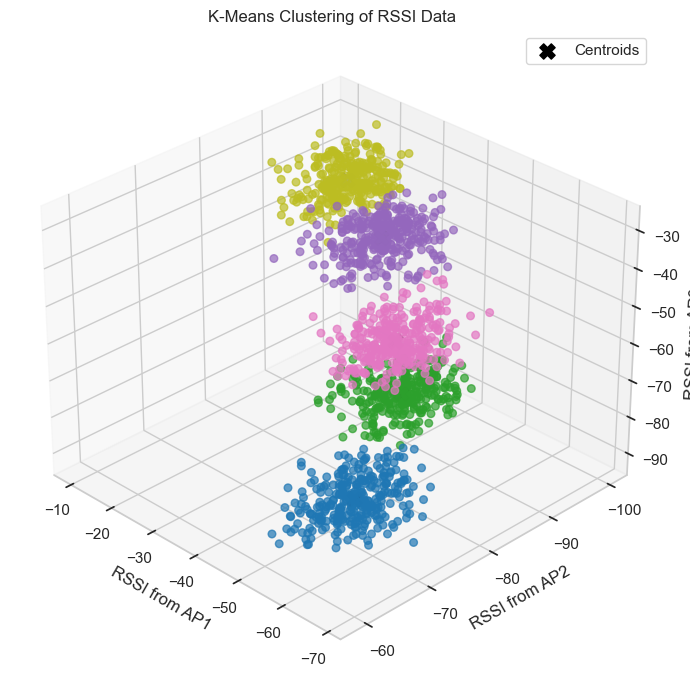

In [44]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign a color per cluster
colors = plt.cm.tab10(assignments / K)

# Scatter plot of the clustered points
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, alpha=0.7, s=30)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='black', marker='X', s=120, label='Centroids')

# Set labels
ax.set_xlabel('RSSI from AP1')
ax.set_ylabel('RSSI from AP2')
ax.set_zlabel('RSSI from AP3')
ax.set_title('K-Means Clustering of RSSI Data')

# Adjust perspective for better visibility
ax.view_init(elev=30, azim=135)  # You can tweak these values

# Add grid and legend
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [48]:
# Ground truth
true_labels = labels_data['position'].values
mapped_labels = np.zeros_like(assignments)

for k in range(K):
    mask = (assignments == k)
    if np.any(mask):
        mapped_labels[mask] = mode(true_labels[mask])[0][0]

# Accuracy
accuracy = np.mean(mapped_labels == true_labels)
print(f'Clustering accuracy: {accuracy:.2%}')

Clustering accuracy: 95.87%


/var/folders/f3/l5b9z7s17xn7qbzqvq11y71m0000gn/T/ipykernel_23065/734655019.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mapped_labels[mask] = mode(true_labels[mask])[0][0]
